# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl


# Thalamocortical Relay Neuron

Here we look into an example of a more complex neuron model with multiple dendrites and diverse ion channels. It is a model of a thalamocortical relay neuron, made by Zeldenrust et al. (Zeldenrust F et al. (2018) PLoS Comput Biol 14:e1005960), which has rich expression of the T-type calcium channels in dendrites.

In [1]:
%%bash
nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/tutorial_5
ITGHK.mod ITOhmic.mod Ih_des93.mod MorrisLecar.mod cadecay.mod hh2.mod ic.mod il.mod netstim2.mod
ITGHK.mod ITOhmic.mod Ih_des93.mod MorrisLecar.mod cadecay.mod hh2.mod ic.mod il.mod netstim2.mod
"/usr/local/nrn/x86_64/bin/nocmodl" ITGHK
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o ITGHK.lo ITGHK.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c ITGHK.c  -fPIC -DPIC -o .libs/ITGHK.o
"/usr/local/nrn/x86_64/bin/nocmodl" ITOhmic
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o ITOhmic.lo ITOhmic.c
libtool: compile:  mpicc

Translating ITGHK.mod into ITGHK.c
Thread Safe
Translating ITOhmic.mod into ITOhmic.c
Thread Safe
Translating Ih_des93.mod into Ih_des93.c
NEURON's CVode method ignores conservation
Thread Safe
Translating MorrisLecar.mod into MorrisLecar.c
Thread Safe
Translating cadecay.mod into cadecay.c
Thread Safe
Translating hh2.mod into hh2.c
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Translating ic.mod into ic.c
Notice: This mechanism cannot be used with CVODE
Thread Safe
Translating il.mod into il.c
Notice: This mechanism cannot be used with CVODE
Thread Safe
Translating netstim2.mod into netstim2.c
Thread Safe


In [2]:
from neuron import h, gui
from thalamocortical_neuron import TCN

Here we create one cell:

In [3]:
cell = TCN()

## 1. Voltage clamp experiment

Here we demonstrate a voltage clamp simulation to probe the T-type calcium current in a distal dendrite. First we insert an electrode and run a step current sequence of

1. resting membrane potential (-74 mV),
2. small depolarization (-73.5 mV),
3. resting potential.

In [4]:
vc = h.SEClamp(cell.soma(0.5))

vc.dur1 = 200
vc.dur2 = 200
vc.dur3 = 200
vc.amp1 = -74
vc.amp2 = -73.5
vc.amp3 = -74


Then, we probe the calcium currents in a distal dendrites. Here we will run the simulation twice:

1. First, we turn off the ohmic channel and record the current through the GHK channel,
2. Second, then we turn on the ohmic channel while turning off the GHK channel and record the ohmic current.

<IPython.core.display.Javascript object>


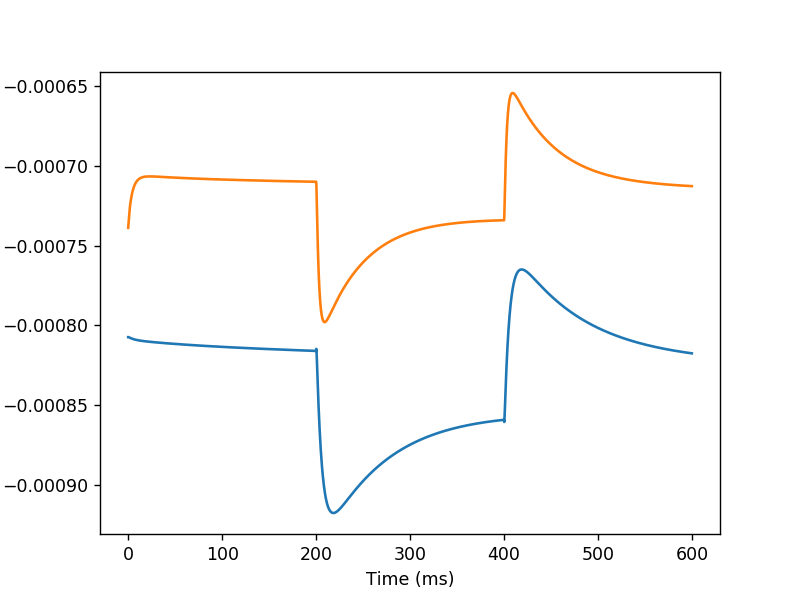

[Text(0,0.5,'Current density (mA/cm2)'), Text(0.5,0,'Time (ms)')]

In [9]:
dt = 0.1 # Record everything at 10 kHz

def run(g=0):
    # First we turn off the ohmic channel
    cell.dend1[1].gcabar_itOhmic = 0       
    
    # Record the GHK current
    vrec = h.Vector()
    vrec.record(cell.dend1[1](0.5)._ref_ica_itGHK, dt)

    # Run a simulation
    h.tstop = vc.dur1+vc.dur2+vc.dur3
        
    h.init()
    h.run()

    # Keep the recording
    v1 = vrec.c()

    # Keep the original pcabar of the GHK channel and turn it off
    pbar_old = cell.dend1[1].pcabar_itGHK
    cell.dend1[1].pcabar_itGHK = 0
    
    # Now we turn on the ohmic current
    cell.dend1[1].gcabar_itOhmic = g
    
    # Record the ohmic current
    vrec = h.Vector()
    vrec.record(cell.dend1[1](0.5)._ref_ica_itOhmic, dt)
    
    h.init()
    h.run()
    
    v2 = vrec.c()
    
    # Reset the neuron: turn off the ohmic channel and set pcabar of the GHK to the original value
    cell.dend1[1].gcabar_itOhmic = 0    
    cell.dend1[1].pcabar_itGHK = pbar_old

    return v1, v2


import matplotlib.pyplot as plt
%matplotlib nbagg
import numpy as np

vrec1, vrec2 = run(6e-3)

t = np.arange(vrec1.size())*dt
fig, ax = plt.subplots()
ax.plot(t, vrec1, t, vrec2)
ax.set(xlabel='Time (ms)', ylabel='Current density (mA/cm2)')

## 2. Current clamp experiment

Here we demonstrate an usual clamp simulation. Be sure to **restart the kernel at this point**.


In [1]:
from neuron import h, gui
from thalamocortical_neuron import TCN

cell = TCN()

# Insert a current clamp electrode
ic = h.IClamp(cell.soma(0.5))

The rest must be familiar to you: we inject a bit of current and record the membrane potential to probe how the neuron spikes.

<IPython.core.display.Javascript object>


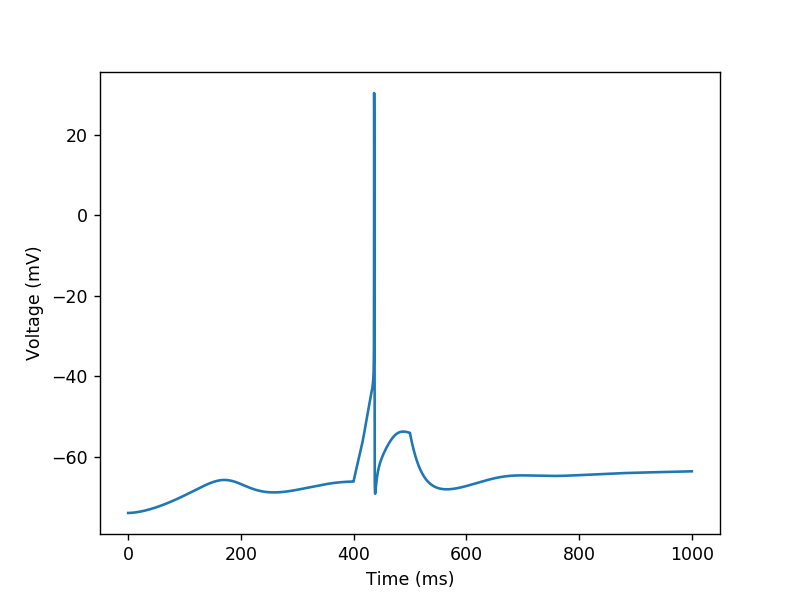

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'Time (ms)')]

In [3]:
ic.amp = 0.1
ic.dur = 100
ic.delay = 400

dt = 0.1 # Record everything at 10 kHz

def run():
    
    # Make sure the ohmic current is off
    cell.dend1[1].gcabar_itOhmic = 0
    
    # Record membrane potential
    vrec = h.Vector()
    vrec.record(cell.soma(0.5)._ref_v, dt)
    
    # Run for 1 sec
    h.tstop = 1000
    
    h.init()
    h.run()

    v1 = vrec.c()
    
    return v1

import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg

vrec1 = run()
t = np.arange(vrec1.size())*dt
fig, ax = plt.subplots()
ax.plot(t, vrec1)
ax.set(xlabel='Time (ms)', ylabel='Voltage (mV)')

The cell show *rebound bursting* due to activation of the T-type calcium channel.

<IPython.core.display.Javascript object>


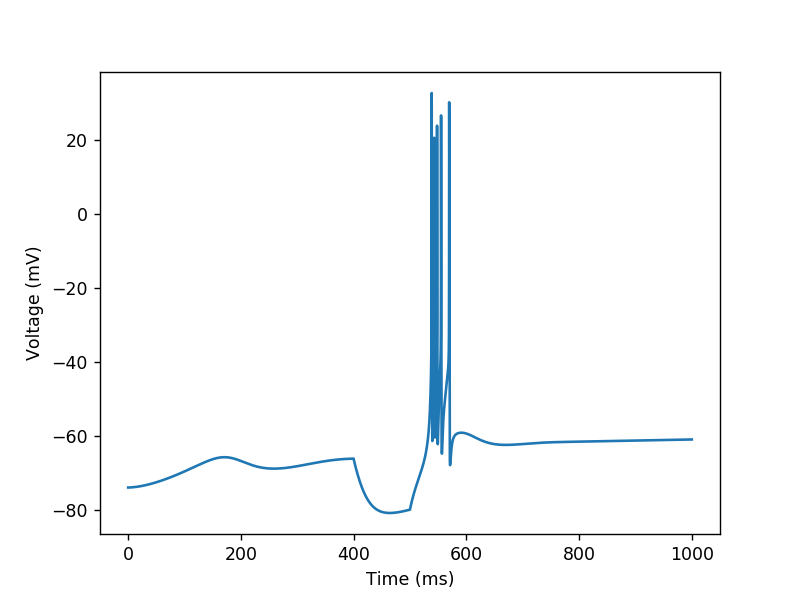

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'Time (ms)')]

In [4]:
ic.amp = -0.1

vrec1 = run()
t = np.arange(vrec1.size())*dt
fig, ax = plt.subplots()
ax.plot(t, vrec1)
ax.set(xlabel='Time (ms)', ylabel='Voltage (mV)')